# Linear model comparison - pi questions vs pi sum scores

## Environment initialization

In [1]:
from __future__ import division, print_function

%autosave 0
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from natsort import natsorted
import itertools

import ipywidgets as widgets
import pandas as pd
import qgrid
import plotly.express as px

import mod_data
import mod_latent
import mod_evaluation

fig_w, fig_h = (4.5, 3.5)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

Autosave disabled


Using TensorFlow backend.


## Notebook variables

In [2]:
data_folder = 'data'
results_folder = 'results'

data_file = '181213_ITQvar.csv'
data_path = os.path.join(data_folder, data_file)

data_file_hold = '190606_holdout_validation_data_PI_items_rescaled.csv'
data_path_hold = os.path.join(data_folder, data_file_hold)

data_file_map ='MappingNamesSumScores.csv'
data_path_map = os.path.join(data_folder, data_file_map)

## Import train and validation data

In [3]:
df_sumscores = mod_data.open_df_sumscores(data_path)
df_questions = mod_data.open_df_questions(data_path)

df_hold_sumscores = mod_data.open_df_hold_sumscores(data_path_hold)
df_hold_questions = mod_data.open_df_hold_questions(data_path_hold, data_path_map)

assert(set(df_questions.columns)==set(df_hold_questions.columns))
assert(set(df_sumscores.columns)==set(df_hold_sumscores.columns))

print('Dataset sum scores')
display(df_sumscores[:3])

print('Dataset questions')
display(df_questions[:3])

print('Holdout sum scores')
display(df_hold_sumscores[:3])

print('Holdout set questions')
display(df_hold_questions[:3])

df_train = df_questions
df_val = df_hold_questions

y_name = 'logits'
y_train, y_logits_train = mod_latent.modelPP(np.array(df_sumscores))
y_val, y_logits_val = mod_latent.modelPP(np.array(df_hold_sumscores))

Dataset sum scores


,bas,rpa_PosRum,panas_pos,teps,shs,rpa_damp,panas_neg,psas,first,rrs,acs,pi,ipip_e,ipip_a,ipip_n,jtv,FSS
0,34,16,25,85,25,7,19,29,21,16,17,190.439088,9,19,13,36,52
1,40,24,36,85,23,10,13,30,20,14,21,181.000000,12,16,12,49,48
2,37,26,31,80,19,10,28,41,25,18,20,192.588889,14,20,11,49,50


Dataset questions


,ACSR_Q1,ACSR_Q2,ACSR_Q3,ACSR_Q4,ACSR_Q5,ACSR_Q6,ACSR_Q7,ACSR_Q8,ACSR_Q9,ACSR_Q10,...,TEPS_Q9,TEPS_Q10,TEPS_Q11,TEPS_Q12,TEPS_Q13,TEPS_Q14,TEPS_Q15,TEPS_Q16,TEPS_Q17,TEPS_Q18
0,0,1,1,0,1,1,1,1,0,1,...,5,5,1,5,6,4,5,5,5,5
1,1,1,1,1,1,1,1,1,1,1,...,6,4,1,4,5,6,5,5,6,5
2,1,1,1,1,1,1,1,1,0,1,...,6,3,1,4,4,4,5,5,6,4


Holdout sum scores


,bas,rpa_PosRum,panas_pos,teps,shs,rpa_damp,panas_neg,psas,first,rrs,acs,pi,ipip_e,ipip_a,ipip_n,jtv,FSS
0,40,19,30,79,19,8,11,33,17,28,15,192.8814,14,15,12,33,20
1,36,18,31,76,13,13,31,56,33,22,1,306.7882,9,18,13,65,46
2,33,18,32,84,24,8,15,53,31,19,11,328.6338,11,20,7,31,27


Holdout set questions


,ACSR_Q1,ACSR_Q2,ACSR_Q3,ACSR_Q4,ACSR_Q5,ACSR_Q6,ACSR_Q7,ACSR_Q8,ACSR_Q9,ACSR_Q10,...,TEPS_Q9,TEPS_Q10,TEPS_Q11,TEPS_Q12,TEPS_Q13,TEPS_Q14,TEPS_Q15,TEPS_Q16,TEPS_Q17,TEPS_Q18
0,1,0,1,1,1,1,0,1,1,1,...,2,2,2,4,4,6,5,5,4,5
1,0,0,0,0,0,0,1,0,0,0,...,3,5,3,6,5,3,4,3,5,4
2,0,0,0,1,1,1,1,1,0,1,...,1,3,4,4,6,5,6,4,5,1


## Test params

In [4]:
model_ref = mod_evaluation.model_linear
model_ref_kwargs = { }
features_quad = True

metric_sort = 'val_mean_squared_error'
metric_filter = ('val_categorical_accuracy', 0.2)

## Load results

In [5]:
questions_info_best = mod_evaluation.from_cache('questions_drop_pi_info_best', results_folder)

questions_stats_best = mod_evaluation.from_cache('questions_drop_pi_stats_best', results_folder)

sum_score_stats_multi = mod_evaluation.from_cache('sum_score_drop_pi_stats_multi', results_folder)

## Process results

In [6]:
questions_stats_m = mod_evaluation.stats_eval(questions_stats_best)

questions_stats_ci = mod_evaluation.stats_eval(
    questions_stats_best, 
    fn=lambda a,**kwargs: mod_evaluation.bootstrap_ci(a, alpha=10, **kwargs),
    selected=[
        'categorical_accuracy','val_categorical_accuracy',
        'mean_squared_error','val_mean_squared_error'
    ]
)

sum_score_stats_multi_m = {
    key: mod_evaluation.stats_eval(
        sum_score_stats_multi[key][0]
    )
    for key in sum_score_stats_multi
}
sum_score_stats_multi_ci = {
    key: mod_evaluation.stats_eval(
        sum_score_stats_multi[key][0], 
        fn=lambda a,**kwargs: mod_evaluation.bootstrap_ci(a, alpha=10, **kwargs),
        selected=[
            'categorical_accuracy','val_categorical_accuracy',
            'mean_squared_error','val_mean_squared_error'
        ]
    )
    for key in sum_score_stats_multi
}

In [64]:
def get_df_questions():
    df = pd.DataFrame([
        [model_id, questions_info_best[model_id]['drop_n'], 17-questions_info_best[model_id]['x_d']]
        + [questions_stats_ci[model_id]['categorical_accuracy'][0], questions_stats_m[model_id]['categorical_accuracy'], questions_stats_ci[model_id]['categorical_accuracy'][1]]
        + [questions_stats_ci[model_id]['val_categorical_accuracy'][0], questions_stats_m[model_id]['val_categorical_accuracy'], questions_stats_ci[model_id]['val_categorical_accuracy'][1]]
        + [questions_stats_ci[model_id]['mean_squared_error'][0], questions_stats_m[model_id]['mean_squared_error'], questions_stats_ci[model_id]['mean_squared_error'][1]]
        + [questions_stats_ci[model_id]['val_mean_squared_error'][0], questions_stats_m[model_id]['val_mean_squared_error'], questions_stats_ci[model_id]['val_mean_squared_error'][1]]    
        for model_id in natsorted(questions_stats_m)
    ])

    df.columns = [
        'model', 'drop_q', 'drop_sum',
        'acc_l', 'acc_m','acc_u',
        'val_acc_l','val_acc_m','val_acc_u',
        'mse_l', 'mse_m', 'mse_u',
        'val_mse_l', 'val_mse_m', 'val_mse_u'
    ]
    df.set_index('model', inplace=True)
    df.sort_values(by=['drop_q'], inplace=True)
    
    return df

def get_df_sumscores(key):

    sum_score_info = sum_score_stats_multi[key][1]
    sum_score_stats_m = sum_score_stats_multi_m[key]
    sum_score_stats_ci = sum_score_stats_multi_ci[key]

    df = pd.DataFrame([
        [model_id, sum_score_info[model_id]['drop_n'], int(key)+1]
        + [sum_score_stats_ci[model_id]['categorical_accuracy'][0], sum_score_stats_m[model_id]['categorical_accuracy'], sum_score_stats_ci[model_id]['categorical_accuracy'][1]]
        + [sum_score_stats_ci[model_id]['val_categorical_accuracy'][0], sum_score_stats_m[model_id]['val_categorical_accuracy'], sum_score_stats_ci[model_id]['val_categorical_accuracy'][1]]
        + [sum_score_stats_ci[model_id]['mean_squared_error'][0], sum_score_stats_m[model_id]['mean_squared_error'], sum_score_stats_ci[model_id]['mean_squared_error'][1]]
        + [sum_score_stats_ci[model_id]['val_mean_squared_error'][0], sum_score_stats_m[model_id]['val_mean_squared_error'], sum_score_stats_ci[model_id]['val_mean_squared_error'][1]]    
        for model_id in natsorted(sum_score_stats_m)
    ])

    df.columns = [
        'model', 'drop_q', 'drop_sum',
        'acc_l', 'acc_m','acc_u',
        'val_acc_l','val_acc_m','val_acc_u',
        'mse_l', 'mse_m', 'mse_u',
        'val_mse_l', 'val_mse_m', 'val_mse_u'
    ]
    df.set_index('model', inplace=True)
    df.sort_values(by=['drop_q'], inplace=True)
    
    return df

df_questions = get_df_questions()
df_sumscores_multi = [get_df_sumscores(str(key+1)) for key in range(len(sum_score_stats_multi_m.keys())-1)]

## Model comparison table

In [65]:
from natsort import natsorted

tab_name = ['pi + q_n'] + ['pi + s_'+item for item in natsorted(sum_score_stats_multi_m.keys())]
children = [qgrid.show_grid(df,precision=4) for df in [df_questions]+[df_sumscore for df_sumscore in df_sumscores_multi]]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, tab_name[i])
display(tab)

## Model comparison plots

In [92]:
import plotly
import plotly.graph_objects as go
from IPython.display import IFrame

def rgb_to_rgba(color_idx, alpha=1):
    color = plotly.colors.DEFAULT_PLOTLY_COLORS[color_idx]
    return 'rgba'+color[3:-1]+', '+str(alpha)+')'

for y_name, y_u_name, y_l_name, title in [
    ['val_acc_m', 'val_acc_u', 'val_acc_l', 'Accuracy - validation'],
    ['val_mse_m', 'val_mse_u', 'val_mse_l', 'MSE - validation']
]:
    fig = go.Figure()
    
    fig.update_layout(
        title=go.layout.Title(
            text=title,
            x=0.5
        )
    )
    for plot_idx, (name, data) in enumerate(zip(
        ['pi+q_n']+ ['pi + s_'+item for item in natsorted(sum_score_stats_multi_m.keys())],
        [df_questions]+[df_sumscore for df_sumscore in df_sumscores_multi]
    )):

        x = data['drop_q'].tolist()
        y = data[y_name].tolist()
        y_u = data[y_u_name].tolist()
        y_l = data[y_l_name].tolist()
        text = data.index.values.tolist()

        fig.add_trace(go.Scatter(
            x=x+x[::-1],
            y=y_u+y_l[::-1],
            fill='toself',
            fillcolor=rgb_to_rgba(plot_idx, 0.2),
            line_color='rgba(255,255,255,0)',
            name=name+' ci'
        ))
        fig.add_trace(go.Scatter(
            x=x, y=y,
            line_color=rgb_to_rgba(plot_idx, 0.6),
            mode='lines',
            text=text,
            name=name
        ))

#     fig.show()
    plotly.offline.plot(fig, filename = title+'.html', auto_open=False)
    

    display(IFrame(src='./'+title+'.html', width=700, height=600))

<IPython.core.display.Javascript object>


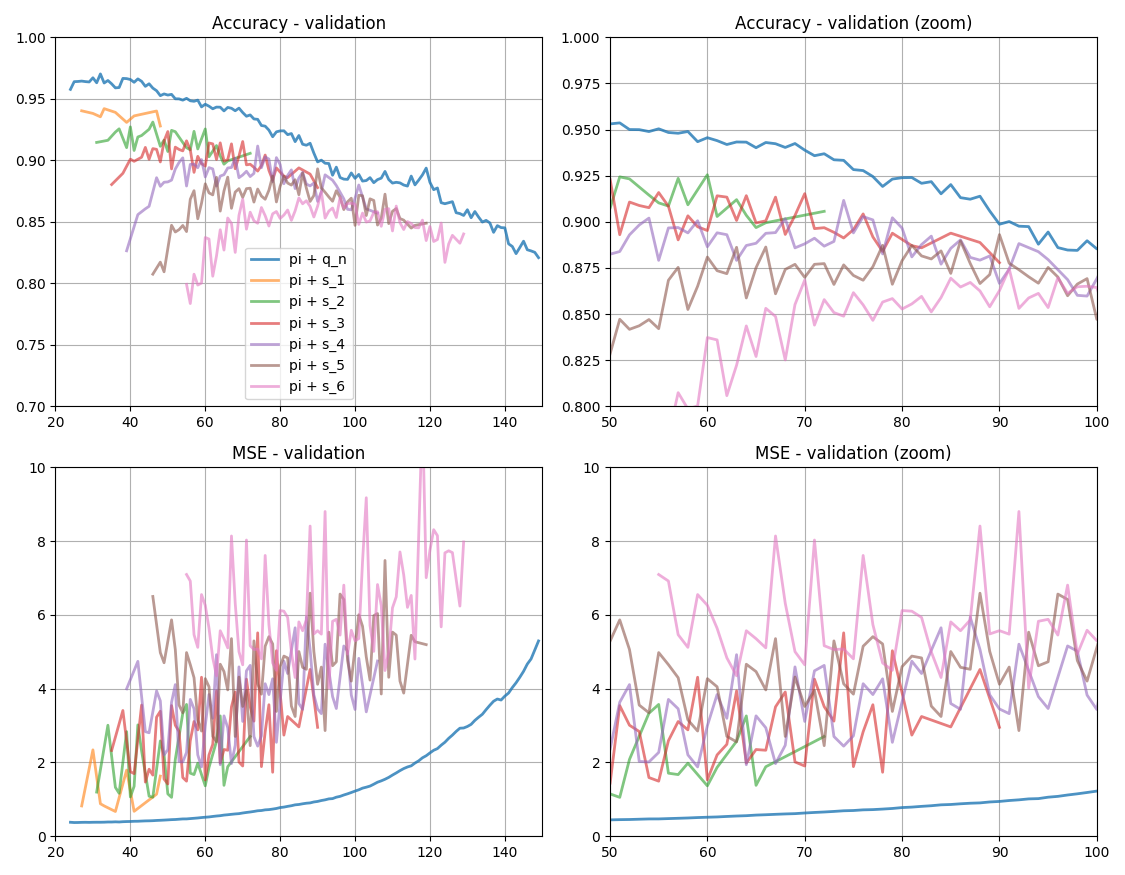

In [11]:
plot_args = [
    ['val_categorical_accuracy', 'Accuracy - validation', [0.7,1], [20,150]],
    ['val_categorical_accuracy', 'Accuracy - validation (zoom)', [0.8,1], [50,100]],
    ['val_mean_squared_error', 'MSE - validation', [0,10], [20,150]],
    ['val_mean_squared_error', 'MSE - validation (zoom)', [0,10], [50,100]],
]

fig, ax = plt.subplots(2, 2, figsize=(2.5*fig_w, 2.5*fig_h))

for my_idx, (my_metric, my_title, my_ylim, my_xlim) in enumerate(plot_args):
    plt.sca(ax.flatten()[my_idx])
    mod_evaluation.plot_stats_evolution(
        questions_stats_best, questions_info_best, my_metric, 
        models=natsorted(questions_stats_best), recycle=True, 
        ci=None, label='pi + q_n'
    )
    
    for n in sorted(sum_score_stats_multi):
        stats_best, info_best = sum_score_stats_multi[n]
        models_list = list(stats_best)

        top_idx = np.argsort([info_best[key]['drop_n'] for key in models_list])
        models_sorted_n = [models_list[idx] for idx in top_idx]
        label = 'pi + s_' + str(n)

        mod_evaluation.plot_stats_evolution(
            stats_best, info_best, my_metric,
            models=models_sorted_n, color='C'+str(n),
            recycle=True, ci=None, label=label, alpha_mean=0.6
        )
        
    plt.gca().set_title(my_title)
    plt.ylim(my_ylim)
    plt.xlim(my_xlim)
    if my_idx==0:
        plt.legend()
    plt.grid(axis='both')
    
plt.tight_layout()
fig.canvas.draw()
plt.show()

## Model validation

In [12]:
# my_models = [models[idx] for idx in range(0,100,10)]
# my_cols_exc = [cols_exc[idx] for idx in range(0,100,10)]

# stats_train, stats_val, _ =  mod_evaluation.model_train_questions(
#     df_train, y_logits_train, df_val, y_logits_val, 
#     model_ref, my_models, my_cols_exc,
#     features_quad=features_quad,
#     **model_ref_kwargs
# )

In [13]:
# print('train \tval\t drop\t name')
# for name_idx, name in enumerate(my_models):
    
#     print(
#         '{:.4f}'.format(stats_train[name]['categorical_accuracy']), 
#         '\t{:.4f}'.format(stats_val[name]['categorical_accuracy']), 
#         '\t', len(my_cols_exc[name_idx]), '\t', name
#     )

## Confusion matrices from CV and validation

In [14]:
# from IPython.core.display import HTML
# import pandas as pd

# print('mean train \t mean val')
# print('train \t\t val')

# for name_idx, name in enumerate(my_models):
    
#     display(
#         HTML(
#             '<style> div>table { display: inline} </style>'
#             + '<h4>'+name+'</h4>'
#             + pd.DataFrame(mod_evaluation.stats_eval(stats_best)[name]['confusion_matrix']).to_html()
#             + pd.DataFrame(mod_evaluation.stats_eval(stats_best)[name]['val_confusion_matrix']).to_html()
#             + '<br>'
#             + pd.DataFrame(stats_train[name]['confusion_matrix']).to_html()
#             + pd.DataFrame(stats_val[name]['confusion_matrix']).to_html()           
#             + '<br>'
#         )
#     )